In [48]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv
import math
from csv import writer
from csv import reader
from scipy import stats
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_text
from sklearn.tree import plot_tree

# Reading Data

In [49]:
# Open file and get the data collected by the Arduino
csv_filename = 'arduino.txt'
data_headers = []
time,temp,hum,pres, dpt = [], [], [], [], []

with open(csv_filename, newline='') as csvfile:
    
    csvreader = csv.reader(csvfile, delimiter=",")
    
    for row in csvreader:
        if data_headers == []:
            data_headers = row
            continue
            
        time.append(float(row[0]))
        temp.append(float(row[1]))
        hum.append(float(row[2]))
        pres.append(float(row[3]))
        

        #constants to calculate dewpoint
        b = 17.62
        c = 243.5
        gamma = math.log(((float(row[2]))/100) + b*(float(row[1])) / (c+(float(row[1])))) 
        tdp = c*gamma / (b-gamma)
        dpt.append(tdp)

# Convert Celsius to Fahrenheit
temp = (temp * 1.8) + 32

# Compute minimum, maximum, and average of each parameter
temp_min, temp_max, temp_avg = np.min(temp), np.max(temp), round(np.mean(temp), 2)
hum_min, hum_max, hum_avg = np.min(hum), np.max(hum), round(np.mean(hum), 2)
pres_min, pres_max, pres_avg = np.min(pres), np.max(pres), round(np.mean(pres), 2)
dpt_min, dpt_max, dpt_avg = np.min(dpt), np.max(dpt), round(np.mean(dpt), 2)

# Print the results
print("Temperature: min = {}, max = {}, avg = {}".format(temp_min, temp_max, temp_avg))
print("Humidity: min = {}, max = {}, avg = {}".format(hum_min, hum_max, hum_avg))
print("Pressure: min = {}, max = {}, avg = {}".format(pres_min, pres_max, pres_avg))
print("Dewpoint: min = {}, max = {}, avg = {}".format(pres_min, pres_max, pres_avg))

TypeError: can't multiply sequence by non-int of type 'float'

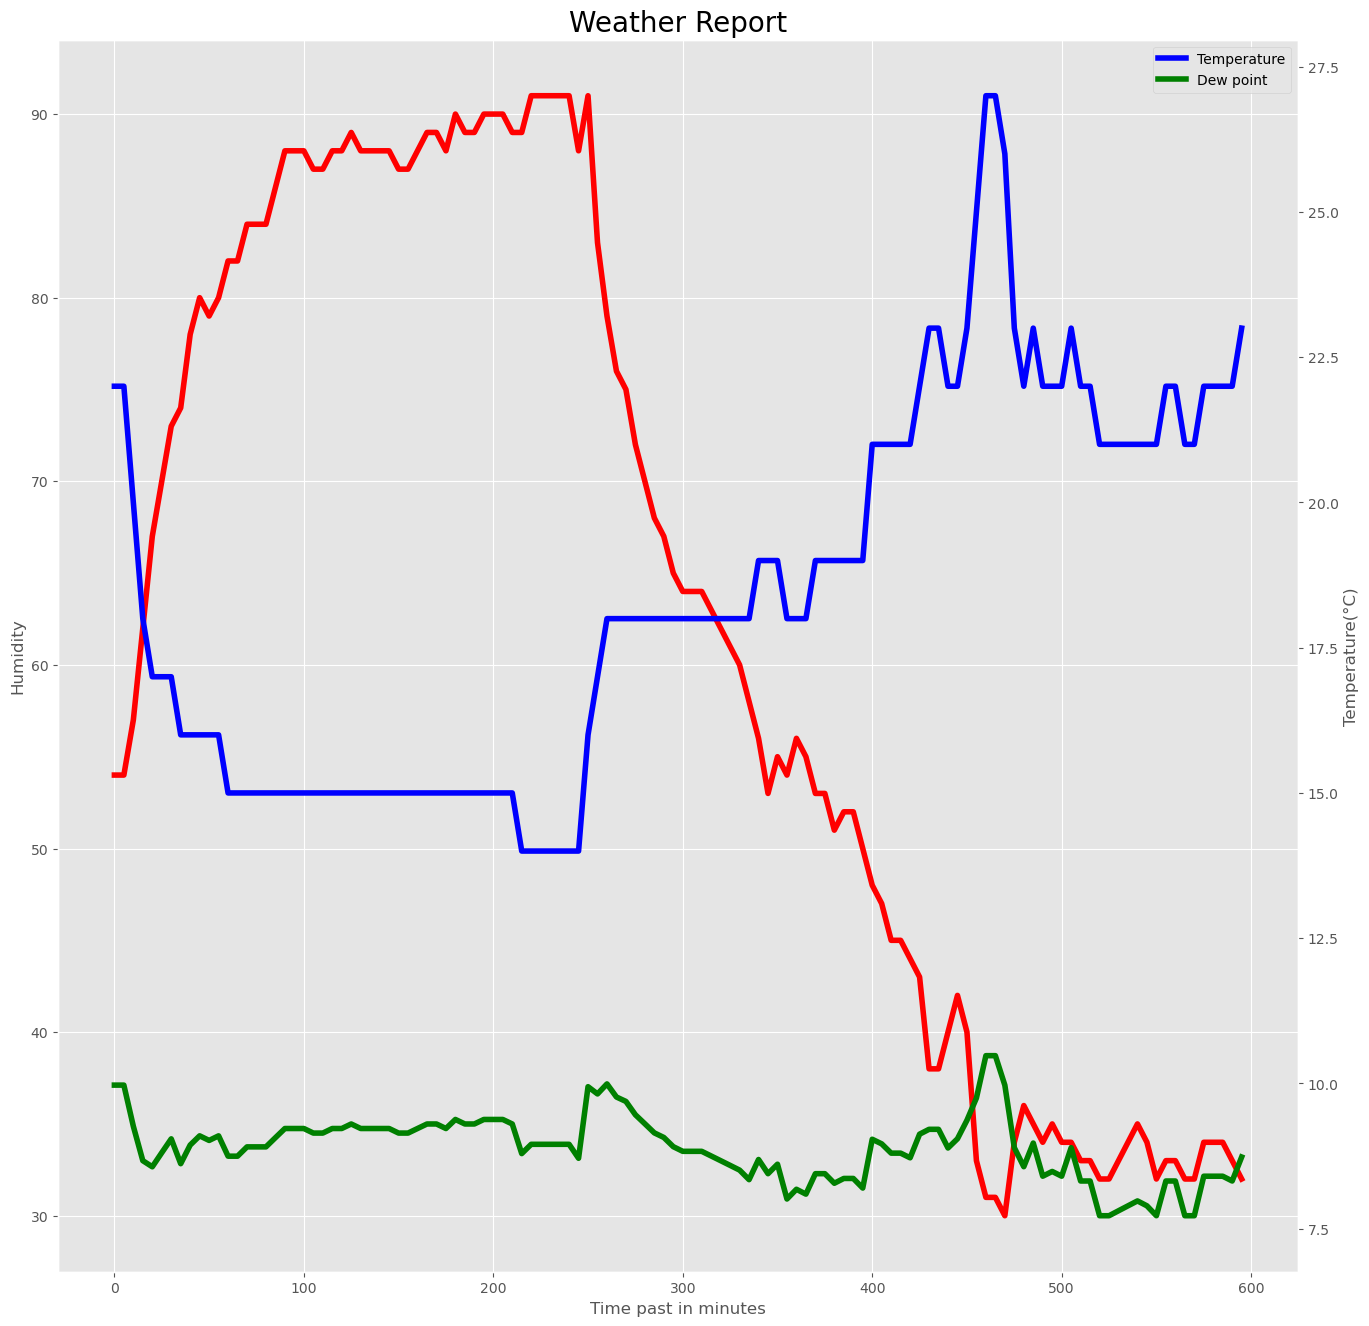

In [ ]:
# Plot the data from the Arduino
#plt_1 = plt.figure(figsize=(16, 14))
fig, ax1 = plt.subplots(figsize=(16, 16))
ax2 = ax1.twinx()  
#ax2.set_ylim(4, 20);

x = time

ax2.plot(x, temp, color = 'blue', label = "Temperature", lw=4)
ax1.plot(x, hum, color = 'red', label = "Humidity", lw=4)
ax2.plot(x, dpt, color = 'green', label = "Dew point", lw=4)
ax1.set_xlabel('Time past in minutes')
ax2.set_ylabel('Temperature(°C)')
ax1.set_ylabel('Humidity')
plt.title('Weather Report', fontsize = 20)
plt.grid()
plt.legend()


#plt.figure().set_figwidth(1200)
#plt.figure().set_figwidth(1200)
plt.show()

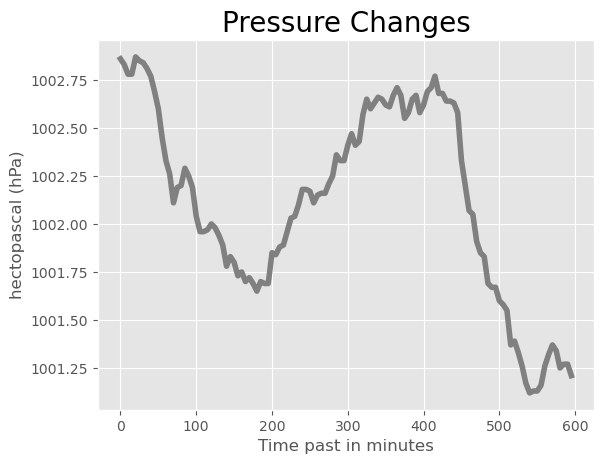

In [ ]:
plt.title('Pressure Changes', fontsize = 20)
plt.ylabel("hectopascal (hPa)")
plt.xlabel("Time past in minutes")
plt.plot(x, pres, color = 'grey', label = "Pressure", lw=4)

# Nearest Neighbor Classification Algorithm (NN_KNN)

## Functions

In [ ]:

def getDataFromCSV(filename):
   # read the CSV file
    data = pd.read_csv('boston_weather_data.csv')
    return data

def createTestCase(minH, maxH, minG, maxG):
    #Create a test case minG
    #nTestCaseH and nTestCaseG are normalized 
    #testCaseH and testCaseG are not normalized
    nTestCaseH, nTestCaseG = np.random.uniform(size=2)
    testCaseH = (nTestCaseH * (maxH - minH)) + minH
    testCaseG = (nTestCaseG * (maxG - minG)) + minG
    return nTestCaseH, nTestCaseG, testCaseH, testCaseG


'''
PURPOSE: normalize a NumPy array
PARAMETERS: NumPy array to be normalized
RETURNS: the normalized array, the minimum value of the old array, and the maximum value of the old array.
'''
def normalizeData(array):
    #Find min
    min = np.amin(array)
    #Fin max
    max = np.amax(array)
    #Claculate the scaled values
    scaled = (array - min)/(max - min)
    #Return them
    return scaled, min, max

'''
PURPOSE: creates a random test case that falls within the
        minimum and maximum values of the training data
PARAMETERS: min and max value of training data
RETURNS: normalized and not-normalized test case
'''

def createTestCase(minH, maxH, minG, maxG):
    print("  -Generating a random test case-  ")
    #generate random test cases for hemoglobin and glucose
    testCaseH = random.randint(int(minH), int(maxH)+1)
    testCaseG = random.randint(int(minG), int(maxG)+1)

    print("High Dew Point:", testCaseH)
    print("Avg Temp:", testCaseG)

    #normalize random test cases
    newHemoglobin = (testCaseH - minH)/(maxH - minH)
    newGlucose = (testCaseG - minG)/(maxG - minG)

    return newHemoglobin, newGlucose, testCaseH, testCaseG
    
'''
PURPOSE: trains and runs the Nearest Neighbor algorithm
PARAMETERS: dataset, parameter_X, parameter_Y, testCase_X, testCase_Y
RETURNS: normalized and not-normalized test case
'''
def NearestNeighbor(filtered_data, high_dew_point, avg_temp, classification, testCaseH, testCaseG): 
    # Calculate distances between test case and each data point
    distances = np.sqrt((high_dew_point - testCaseH) ** 2 + (avg_temp - testCaseG) ** 2)

    # Find the index of the closest point
    closestIdx = np.argmin(distances)

    # Get the classification of the closest point
    closestClassification = classification[closestIdx]

    #Get the closest point's classification
    if (closestClassification == 1):
        print("RESULT: Test day will probably rain (class = 1)")
    else:
        print("RESULT: Test day will probably not rain (class = 0)")

    #plot non-normalized data
    colors = {0: 'red', 1: 'blue'}
    plt.scatter(filtered_data['High Dew Point (F)'], filtered_data['Avg Temp (F)'], c=filtered_data['Classification'].apply(lambda x: colors[x]))
    plt.scatter(testCaseH, testCaseG, c='yellow', label='Test Case')
    plt.scatter(filtered_data.loc[closestIdx, 'High Dew Point (F)'], filtered_data.loc[closestIdx, 'Avg Temp (F)'], c='black', label='Closest point')
    plt.xlabel('High Dew Point (F)')
    plt.ylabel('Avg Temp (F)')
    plt.title('Dew Point vs. Avg Temp')
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Not Raining', markerfacecolor='r', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='Raining', markerfacecolor='b', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='Test Case', markerfacecolor='y', markersize=10),
                        plt.Line2D([0], [0], marker='o', color='w', label='Closest point', markerfacecolor='black', markersize=10)]
    plt.legend(handles=legend_elements)
    plt.show()


## Script

Data analysis and exploration. We are trying to find which variables most correlate to the chance of raining.

In [ ]:
filename = "boston_weather_data.csv"
data = getDataFromCSV(filename)

# Select only the data points with "Rain" in the "Events" column
rain_data = data[data['Events'] == 'Rain']

# # One-hot encode the "Events" column
# one_hot = pd.get_dummies(data['Events'])

# filter the data to include April to July only
months = [4, 5, 6, 7]
rain_data = data[data['Month'].isin(months)]

# filter days that snowed
rain_data = rain_data[rain_data['Events'] != 'Snow']

# Add a new column called "Classification" which is 1 if it "Rained" or "Both"
rain_data['Classification'] = 0
rain_data.loc[rain_data['Events'].isin(['Rain', 'Both']), 'Classification'] = 1

# Combine one-hot encoded columns with original data
# data = pd.concat([data, one_hot], axis=1)

# Calculate correlations with "Rain" event
corr_matrix = rain_data.corr()['Classification'].sort_values()

# Print correlations in descending order
print(corr_matrix[::-1])

Classification               1.000000
High Humidity (%)            0.579963
Avg Humidity (%)             0.568245
Low Humidity (%)             0.486357
Precip (in)                  0.424982
Avg Dew Point (F)            0.246407
High Dew Point (F)           0.228692
Low Dew Point (F)            0.211514
High Wind (mph)              0.138979
High Wind Gust (mph)         0.125209
Snowfall (in)                0.054959
Avg Wind (mph)               0.006958
Month                       -0.002252
Day                         -0.011068
Low Temp (F)                -0.014913
Year                        -0.037238
Avg Temp (F)                -0.077534
High Visibility (mi)        -0.097391
High Temp (F)               -0.125433
High Sea Level Press (in)   -0.230084
Avg Sea Level Press (in)    -0.293286
Low Sea Level Press (in)    -0.320492
Avg Visibility (mi)         -0.521907
Low Visibility (mi)         -0.701075
Name: Classification, dtype: float64


This script will run the Nearest Neighbor algorithm to train the model, generate a test point (with random values), and classify it as a raining day or not.

  -Generating a random test case-  
High Dew Point: 62
Avg Temp: 82
RESULT: Test day will probably not rain (class = 0)


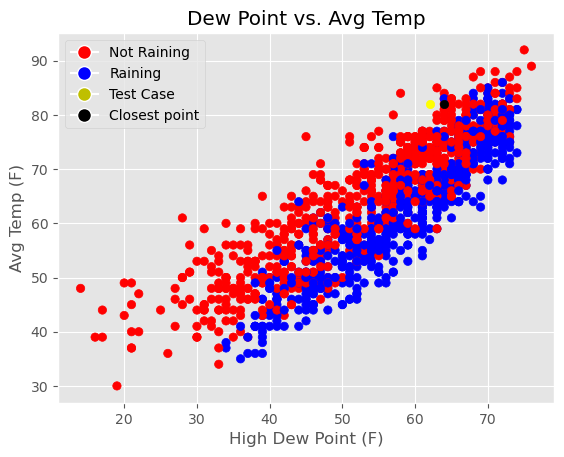

In [ ]:


filename = "boston_weather_data.csv"
data = getDataFromCSV(filename)

# # drop rows containing "None" in "Events" column
# data = data.drop(index=data.loc[data['Events'] == 'None'].index)

# filter the data to include April to July only
months = [4, 5, 6, 7]
filtered_data = data[data['Month'].isin(months)]

# filter days that snowed
filtered_data = filtered_data[filtered_data['Events'] != 'Snow']

# Add a new column called "Classification" which is 1 if it "Rained" or "Both"
filtered_data['Classification'] = 0
filtered_data.loc[filtered_data['Events'].isin(['Rain', 'Both']), 'Classification'] = 1

# Reset the indexes
filtered_data = filtered_data.reset_index(drop=True)

# For testing. Comment this out later.
# filtered_data = filtered_data.iloc[:10]

#Since we found high correlation of rain with high dew point and avg temp, we are going to use them in our model
high_dew_point = filtered_data['High Dew Point (F)']
avg_temp = filtered_data['Avg Temp (F)']
classification = filtered_data['Classification'] 


#normalize the data and get min and max
scaledG, minG, maxG = normalizeData(high_dew_point)
scaledH, minH, maxH = normalizeData(avg_temp)

#Create a test case minG
#nTestCaseH and nTestCaseG are normalized 
#testCaseH and testCaseG are not normalized
nTestCaseH, nTestCaseG, testCaseH, testCaseG = createTestCase( minG, maxG, minH, maxH)

#Use the Nearest Neighbor Classification to classify the test case
NearestNeighbor(filtered_data, high_dew_point, avg_temp, classification, testCaseH, testCaseG)


Now we want to use the collected data, instead of random generated test data, on this model to predict if it's going to rain or not.

In [ ]:
filename = "boston_weather_data.csv"
data = getDataFromCSV(filename)

# # drop rows containing "None" in "Events" column
# data = data.drop(index=data.loc[data['Events'] == 'None'].index)

# filter the data to include April to July only
months = [4, 5, 6, 7]
filtered_data = data[data['Month'].isin(months)]

# filter days that snowed
filtered_data = filtered_data[filtered_data['Events'] != 'Snow']

# Add a new column called "Classification" which is 1 if it "Rained" or "Both"
filtered_data['Classification'] = 0
filtered_data.loc[filtered_data['Events'].isin(['Rain', 'Both']), 'Classification'] = 1

# Reset the indexes
filtered_data = filtered_data.reset_index(drop=True)

# For testing. Comment this out later.
# filtered_data = filtered_data.iloc[:10]

#Since we found high correlation of rain with high dew point and avg temp, we are going to use them in our model
high_dew_point = filtered_data['High Dew Point (F)']
avg_temp = filtered_data['Avg Temp (F)']
classification = filtered_data['Classification'] 


#normalize the data and get min and max
scaledG, minG, maxG = normalizeData(high_dew_point)
scaledH, minH, maxH = normalizeData(avg_temp)

#predict with the data we have TODO
nTestCaseH, nTestCaseG, 

#Use the Nearest Neighbor Classification to classify the test case
NearestNeighbor(filtered_data, high_dew_point, avg_temp, classification, testCaseH, testCaseG)

# K-Means Clustering Classification Algorithm (KMC)

In [ ]:
# *******************************************************************
# FUNCTIONS
# *******************************************************************

'''
PURPOSE: helper function for calculateDistArr. Calculates the distance between gs and hs and provided centroids. 
PARAMETERS: which centroid (k), glucose array, hemoglobin array, and centroid arrays
RETURNS: calculated distance
'''
def calculateDistForK(k, gs, hs, centroids):
    #Create the array to store the calculated distances
    calcDist = np.zeros(len(gs))

    #Get the kth point 
    gCent = centroids[k, 0]
    hCent = centroids[k,1]

    #Calculate the distance from centroid to 
    # kth glucose and hemoglobin points
    distanceG = (gs - gCent)**2
    distanceH = (hs - hCent)**2
    calcDist = (distanceG + distanceH)*0.5

    return calcDist

'''
PURPOSE: calculate the distances between points and centroids
PARAMETERS: number of centroids (K), glucose array, hemoglobin array, and centroid arrays
RETURNS: array with distances from glucose and hemoglobin points to
centroid points
'''
def calculateDistArr(K, gs, hs, centroids):

    #Initial distance array has 0 rows
    distanceArr = np.zeros((0, len(gs)))

    for k in range(K):
        #get a new row for k using a helper function
        newRow = calculateDistForK(k, gs, hs, centroids)

        #add it to distance array, this is the k-th centroid
        #distances
        distanceArr = np.vstack([distanceArr, newRow])

    return distanceArr

'''
PURPOSE: uses the distance array to find the centroid closest to
each point, assigning it a classification (from 0 to K)
PARAMETERS: array with distances for each point, number of centroids (K), number of points (length of data taken from file)
RETURNS: array with assignments for all points
'''
def calculateAssignment(distanceArr, K, dataLength):
    # For each point
    assignment = np.zeros(dataLength)
    dist = np.zeros(K)
    for i in range(dataLength):
        for k in range(K):
            #Distance from point i from centroid k is 
            # distanceArr[k,i]
            dist[k] = distanceArr[k,i]

        #Find the index of the closest centroid for this point
        #This is its classification (from 0 to K)
        assignment[i] = np.argmin(dist)
    
    return assignment 

'''
PURPOSE: Updates the location of each centroid by finding the mean of each feature of the observations (data points) currently assigned to that centroid
PARAMETERS: number of centroids (K), data array, and centroids arrays
RETURNS: updated centroid array
'''
def updateCentroids(K, gs, hs, assignment, centroids):
    #Create newCentroids that will store the updated values
    newCentroids = np.zeros((K, 2)) 

    for k in range(K):
        #if there is any assignment == k
        if((assignment == k).any()):
            newCentroids[k,0] = float(np.mean(gs[assignment==k]))
            newCentroids[k,1] = float(np.mean(hs[assignment==k]))
        # print("Centroid",k,"location is now", newCentroids[k,0], newCentroids[k,1])
    return newCentroids

'''
PURPOSE: "Denormalizes" the centroids' data. Transform values
ranging from 0 to 1 into values ranging from max and min 
PARAMETERS: denormalized data array and K
RETURNS: denormalized centroids array
'''
def denormalize(centroids, h, g, K):
    #Find min
    minH = np.amin(h)
    minG = np.amin(g)
    #Fin max
    maxH = np.amax(h)
    maxG = np.amax(g)
    #Calculate the denormalized values
    #dCentroids = np.zeros((2, K))
    dCentroids = centroids
    for k in range(K):
        dCentroids[k,0] = (centroids[k][0] * (maxG - minG)) + minG
        dCentroids[k,1] = (centroids[k][1] * (maxH - minH)) + minH
    
    #Return
    return dCentroids

Generated centroids: [[0.19949147 0.45898695]
 [0.55326819 0.69643915]]
6 iterations.
Centroid features (locations): 
Centroid 0 43.48207171314745 51.66932270916335
Centroid 1 63.14701803051319 71.3994452149793
KMC Classifications:
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0


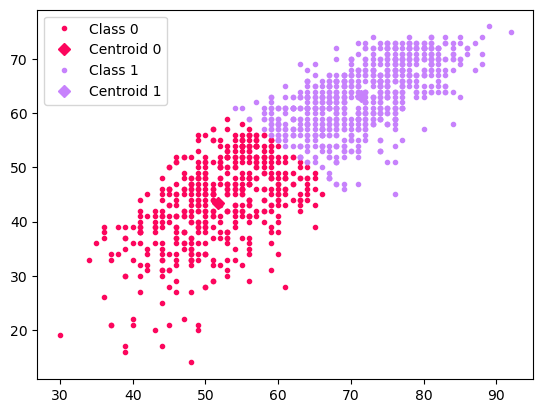

In [ ]:
'''
This is for testing. We want to learn how to properly generate centroid points. 
'''

# Select K random centroid points. These should fall within the range of the feature sets.
K = 2

#Generate a 2D array for centroids
#column 0 = glucose
#column 1 hemoglobin
centroids = np.random.rand(K,2) 

print("Generated centroids:", centroids)

data = getDataFromCSV(filename) 

# filter the data to include April to July only
months = [4, 5, 6, 7]
filtered_data = data[data['Month'].isin(months)]

# filter days that snowed
filtered_data = filtered_data[filtered_data['Events'] != 'Snow']

# Add a new column called "Classification" which is 1 if it "Rained" or "Both"
filtered_data['Classification'] = 0
filtered_data.loc[filtered_data['Events'].isin(['Rain', 'Both']), 'Classification'] = 1

# Reset the indexes
filtered_data = filtered_data.reset_index(drop=True)

# For testing. Comment this out later.
# filtered_data = filtered_data.iloc[:10]

#Since we found high correlation of rain with high dew point and avg temp, we are going to use them in our model
g = filtered_data['High Dew Point (F)']
h = filtered_data['Avg Temp (F)']
c = filtered_data['Classification'] 

#The number of points will be the size of any g, h, or c
dataLength = len(g)

#Normalize arrays
gs, gmin, gmax = normalizeData(g)
hs, smin, smax = normalizeData(h)

loop = 1
iterations = 0
while(loop):
    #Count how many iterations are needed
    iterations+= 1

    #Calculate distances from points to centroids
    distanceArr = calculateDistArr(K, gs, hs, centroids)

    #Find the assignment (from 0 to K) for each point
    assignment = calculateAssignment(distanceArr, K, dataLength)

    #Update centroids
    newCentroids = updateCentroids(K, gs, hs, assignment, centroids)

    #If centroids did not change, stop the loop
    if ((newCentroids == centroids).all()):
        loop = 0

    centroids = newCentroids

#Denormalize the centroids
dCentroids = denormalize(centroids, h, g, K)

print(iterations, "iterations.")
print("Centroid features (locations): ")
for i in range (K):
    print("Centroid", i, dCentroids[i][0], dCentroids[i][1])
    
# print("Original classifications", c[35:55])
print("KMC Classifications:")
for i in range(dataLength):
    print(assignment[i])


plt.figure()

#Converting to int
assignment = assignment.astype(int)

for i in range(assignment.max()+1):
    rcolor = np.random.rand(3,)
    plt.plot(h[assignment==i],g[assignment==i], ".", label = "Class " + str(i), color = rcolor)
    plt.plot(centroids[i, 1], centroids[i, 0], "D", label = "Centroid " + str(i), color = rcolor)
plt.legend()
plt.show()

Now let's implement a k-nearest neighbors classifier.

RESULT: Test day will probably rain (class = 1)


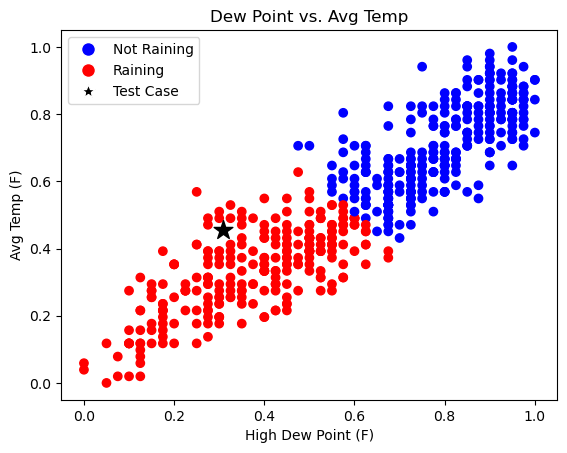

In [ ]:

def getDataFromCSV(filename):
    data = pd.read_csv(filename)
    return data


def filterDataByMonths(data, months):
    filtered_data = data[data['Month'].isin(months)]
    return filtered_data


def filterDataByEvents(data, events):
    filtered_data = data[data['Events'].isin(events)]
    return filtered_data


def normalizeData(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    scaled_data = np.reshape(scaled_data, (-1, 2))
    min_val = scaler.data_min_
    max_val = scaler.data_max_
    return scaled_data, min_val, max_val


def createTestCase(min_val_h, max_val_h, min_val_t, max_val_t):
    testCaseH = np.random.uniform(min_val_h, max_val_h)
    testCaseG = np.random.uniform(min_val_t, max_val_t)
    nTestCaseH = (testCaseH - min_val_h) / (max_val_h - min_val_h)
    nTestCaseG = (testCaseG - min_val_t) / (max_val_t - min_val_t)
    return nTestCaseH, nTestCaseG, testCaseH, testCaseG

# Number of clusters
n_clusters = 2

# Load data from CSV file
filename = "boston_weather_data.csv"
data = getDataFromCSV(filename)

# Filter the data by months and events
months = [4, 5, 6, 7]
events = ['Rain', 'Both']
filtered_data = filterDataByMonths(data, months)
filtered_data = filterDataByEvents(filtered_data, events)

# Extract the "High Dew Point (F)" and "Avg Temp (F)" columns
X = filtered_data[['High Dew Point (F)', 'Avg Temp (F)']]

# Normalize the data and get the minimum and maximum values of the original data
scaled_X, min_X, max_X = normalizeData(X)

# Create a test case
nTestCaseH, nTestCaseG, testCaseH, testCaseG = createTestCase(min_X[0], max_X[0], min_X[1], max_X[1])
testCase = np.array([[nTestCaseH, nTestCaseG]])

# Perform K-means clustering on the data
kmeans = KMeans(n_clusters, random_state=0).fit(scaled_X)

# Classify the test case based on its closest cluster center
closest_cluster = kmeans.predict(testCase)

if closest_cluster == 1:
    print("RESULT: Test day will probably rain (class = 1)")
else:
    print("RESULT: Test day will probably not rain (class = 0)")

# Plot the data and the test case
colors = {0: 'red', 1: 'blue'}
plt.scatter(scaled_X[:, 0], scaled_X[:, 1], c=kmeans.labels_.astype(float), cmap=plt.cm.get_cmap('bwr', 2))
plt.scatter(testCase[:, 0], testCase[:, 1], c="black", s=200, marker='*', label='Test Case', cmap=plt.cm.get_cmap('bwr', 2))
plt.xlabel('High Dew Point (F)')
plt.ylabel('Avg Temp (F)')
plt.title('Dew Point vs. Avg Temp')
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Not Raining', markerfacecolor='blue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Raining', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='*', color='w', label='Test Case', markerfacecolor='black', markersize=10)]
plt.legend(handles=legend_elements)
plt.show()

# Decision Trees

We start by generating a small decision tree with only 5% of the data to visualize how it works. This will have a small accuracy. The parameters used are Avg Temp (F) and High Humidity (%) only. 

In [ ]:
# Load data from CSV file
filename = "boston_weather_data.csv"
data = pd.read_csv(filename)

# Filter the data by months and events
# filter the data to include April to July only
months = [4, 5, 6, 7]
filtered_data = data[data['Month'].isin(months)]

# filter days that snowed
filtered_data = filtered_data[filtered_data['Events'] != 'Snow']

# filter days that rained and snowed
filtered_data = filtered_data[filtered_data['Events'] != 'Both']

# Add a new column called "Classification" which is 1 if it "Rained" or "Both"
filtered_data['Classification'] = 0
filtered_data.loc[filtered_data['Events'].isin(['Rain', 'Both']), 'Classification'] = 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data[['Avg Temp (F)', 'High Humidity (%)']],
                                                    filtered_data['Classification'],
                                                    test_size=0.95,
                                                    random_state=3)

# Train a decision tree classifier on the training data
clf = DecisionTreeClassifier(random_state=3)
clf.fit(X_train, y_train)

# Test the classifier on the testing data
y_pred = clf.predict(X_test)

# Calculate accuracy of the classifier
accuracy = clf.score(X_test, y_test)
print("Model is trained. Accuracy:", accuracy)

# Visualize the decision tree
plt.figure(figsize=(200,100))
plot_tree(clf, filled=True, feature_names=['Avg Temp (F)', 'High Humidity (%)'], class_names=['Rain', 'None'])
plt.show()

Model is trained. Accuracy: 0.668971477960242


Now we will refine the decision tree. Let's train it using 95% of the data, then test its accuracy with the remaining 5%. The parameters used are Dew Point, Temperature, and Humidity. This gives an accuracy of 82%. 

In [ ]:
# Load data from CSV file
filename = "boston_weather_data.csv"
data = pd.read_csv(filename)

# Filter the data by months and events
# filter the data to include April to July only
months = [4, 5, 6, 7]
filtered_data = data[data['Month'].isin(months)]

# filter days that snowed
filtered_data = filtered_data[filtered_data['Events'] != 'Snow']

# Add a new column called "Classification" which is 1 if it "Rained" or "Both"
filtered_data['Classification'] = 0
filtered_data.loc[filtered_data['Events'].isin(['Rain', 'Both']), 'Classification'] = 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(filtered_data[['Avg Dew Point (F)', 'Avg Temp (F)', 
                                                                   'High Humidity (%)', 'Avg Humidity (%)',
                                                                   "Low Humidity (%)",  "High Dew Point (F)"]],
                                                    filtered_data['Classification'],
                                                    test_size=0.05,
                                                    random_state=11)

# Train a decision tree classifier on the training data
clf = DecisionTreeClassifier(random_state=11)
clf.fit(X_train, y_train)

# Test the classifier on the testing data
y_pred = clf.predict(X_test)

# Calculate accuracy of the classifier
accuracy = clf.score(X_test, y_test)
print("Model is trained. Accuracy:", accuracy)

# Visualize the decision tree
plt.figure(figsize=(200,100))
plot_tree(clf, filled=True, feature_names=['Avg Dew Point (F)', 'Avg Temp (F)', 'High Humidity (%)', 
                                           'Avg Humidity (%)',"Low Humidity (%)",  "High Dew Point (F)"], 
                                           class_names=['Rain', 'None', 'Both'])
plt.show()

Model is trained. Accuracy: 0.8225806451612904


Let's train the model on all the data available, then use it to classify today's chance of raining. 

In [ ]:
# train a decision tree classifier on the entire dataset
clf = DecisionTreeClassifier(random_state=11)
clf.fit(filtered_data[['Avg Dew Point (F)', 'Avg Temp (F)', 'High Humidity (%)', 
                       'Avg Humidity (%)',"Low Humidity (%)",  "High Dew Point (F)"]], 
                       filtered_data['Classification'])

# get the data collected by the Arduino.
avg_dew = 17
high_dew = 47
avg_temp = temp_avg
high_hum = hum_max
avg_hum = hum_avg
low_hum = hum_min

# create new datapoint
new_data = [[avg_dew, avg_temp, high_hum, avg_hum, low_hum, high_dew]]
new_data_df = pd.DataFrame(new_data, columns=['Avg Dew Point (F)', 'Avg Temp (F)', 'High Humidity (%)', 
                                              'Avg Humidity (%)', 'Low Humidity (%)', 'High Dew Point (F)'])

# predict using new data
prediction = clf.predict(new_data_df)

if prediction == 1:
  print("RESULT: Probably raining.")
else:
  print("RESULT: Probably not raining.")


RESULT: Probably not raining.
